# Visualizing embeddings in 3D

The example uses [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to reduce the dimensionality fo the embeddings from 1536 to 3. Then we can visualize the data points in a 3D plot. The small dataset `dbpedia_samples.jsonl` is curated by randomly sampling 200 samples from [DBpedia validation dataset](https://www.kaggle.com/danofer/dbpedia-classes?select=DBPEDIA_val.csv).

### 1. Load the dataset and query embeddings

In [43]:
import pandas as pd

# This is the data that you downloaded from https://www.kaggle.com/danofer/dbpedia-classes?select=DBPEDIA_val.csv 
df = pd.read_csv("data/DBPEDIA_val.csv")


# Use melt() to stack the l1, l2, and l3 columns into a single column named category
df_reshaped = df.melt(id_vars=['text'], value_vars=['l1', 'l2', 'l3'], var_name='level', value_name='category')

# Drop the 'level' column, as it's not needed
df_reshaped = df_reshaped.drop(columns=['level'])

# Reset the index
df_reshaped.reset_index(drop=True, inplace=True)


jsonl_file_path = 'data/dbpedia_samples.jsonl'

with open(jsonl_file_path, mode='w', encoding='utf-8') as jsonl_file:
    jsonl_file.write(df_reshaped.to_json(orient='records', lines=True))


samples = pd.read_json("data/dbpedia_samples.jsonl", lines=True)[:200]

categories = sorted(samples["category"].unique())
print("Categories of DBpedia samples:", samples["category"].value_counts())
samples.head()

FileNotFoundError: [Errno 2] No such file or directory: 'data/DBPEDIA_val.csv'

In [46]:
import openai
openai.api_key = 'Your API Key'

from openai.embeddings_utils import get_embeddings
# NOTE: The following code will send a query of batch size 200 to /embeddings
matrix = get_embeddings(samples["text"].to_list(), engine="text-embedding-ada-002")

### 2. Reduce the embedding dimensionality

In [47]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
vis_dims = pca.fit_transform(matrix)
samples["embed_vis"] = vis_dims.tolist()

### 3. Plot the embeddings of lower dimensionality

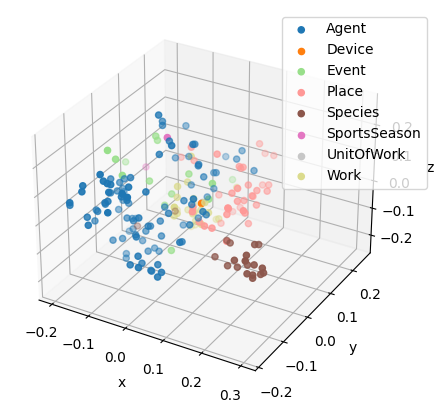

In [54]:
%matplotlib widget # comment out if running locally
import matplotlib.pyplot as plt
import numpy as np

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(projection='3d')
cmap = plt.get_cmap("tab20")

# Plot each sample category individually such that we can set label name.
for i, cat in enumerate(categories):
    sub_matrix = np.array(samples[samples["category"] == cat]["embed_vis"].to_list())
    x=sub_matrix[:, 0]
    y=sub_matrix[:, 1]
    z=sub_matrix[:, 2]
    colors = [cmap(i/len(categories))] * len(sub_matrix)
    ax.scatter(x, y, zs=z, zdir='z', c=colors, label=cat)

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.legend(bbox_to_anchor=(1.1, 1))